In [98]:
# Authors: N. Branson, M. Occhetta., A. Wenteler

In [99]:
import numpy as np
import pandas as pd
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from pypalettes import load_cmap

In [100]:
# These results are produced by running `train.py` in conjunction with the corresponding scFM
df_mlp = pd.read_csv('aggregated_results/mlp_baseline.csv')
df_scgpt = pd.read_csv('aggregated_results/scgpt.csv')
df_scbert = pd.read_csv('aggregated_results/scbert.csv')
df_gf = pd.read_csv('aggregated_results/gf.csv')
df_uce = pd.read_csv('aggregated_results/uce.csv')
df_mean = pd.read_csv('aggregated_results/mean.csv')
df_scf = pd.read_csv('aggregated_results/scfoundation.csv')

## Plotting and data processing functions

In [107]:
spectral_params = ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7'] #'0.8']
def find_mets_by_spectral_params(model, metric_name, raw_data):
    '''find tabular metrics grouped by the spectral params'''
    met_by_sp = {}
    for sp in spectral_params:
        debug_check = f"{model}_{sp}"
        if model in ['mlp_norman', 'test_mean_norman']:
            sp_sub = raw_data[raw_data['Group'] == f'{model}_{sp}']
        else:            
            sp_sub = raw_data[raw_data['data.split'] == float(sp)]
        # if sp_sub[metric_name].isna().all():
        #     met_by_sp[f'{model}_{sp}'] = sp_sub['test/rmse'].values
        # else:
        met_by_sp[f'{model}_{sp}'] = sp_sub[metric_name].values
    return pd.DataFrame(met_by_sp)

def find_spectral_auc(metric_df):
    x = np.array(spectral_params, dtype='float')
    y = metric_df.mean() 
    yerr = metric_df.std() 
    mean_yerr = yerr.mean()
    return auc(x, y), mean_yerr

def plot_spectral_curve(metric_df, err='standard_error', zero_ylb=False, shading=True, errbar=True, c="#D1E7FF", alpha=0.8,
                        plot_shading_c_same=True):
    x = np.array(spectral_params, dtype='float')
    y = metric_df.mean()
    
    yerr = metric_df.std() 
    
    if errbar: #safe to remove if we go with fill_between for errors
        plt.errorbar(x, y, yerr=yerr, color='k', capsize = 3,elinewidth=1.5, linewidth=1.0)    
    else:
        if plot_shading_c_same:
            plot_c = c
        else:
            plot_c = 'k'
        plt.plot(x, y, color=plot_c, linestyle='dashed', marker='o', linewidth=0.5)
        y_lower = y - yerr
        y_upper = y + yerr
        plt.fill_between(x, y_lower, y_upper, color=c, alpha=alpha, 
        #edgecolor='#aad3ff'
        )
    axes = plt.gca()
    y_min, _ = axes.get_ylim()
    #
    if zero_ylb:
        y_min = 0
    if shading:
        plt.fill_between(x=x, y1=y, y2=y_min, color= "#D1E7FF", alpha=1.0)
    
    plt.xlabel('Sparsification Probability')
    plt.ylabel('MSE')


def find_auspc_table(all_model_raw_dfs, model_names, probe_model_ds='mlp_norman', metric_name='test/mse'):
    '''probe_model_ds named in Group col in df above 
    metric_name  name of col for metric of intrest
    '''
    table_auc = {}
    table_yerr = {}
    for m_name, dft in zip(model_names, all_model_raw_dfs):
        if m_name != 'Mean baseline':
            auc, yerr = find_spectral_auc(find_mets_by_spectral_params(probe_model_ds, metric_name, dft))
        else:
            auc, yerr = find_spectral_auc(find_mets_by_spectral_params("test_mean_norman", metric_name, dft))
            
        table_auc[m_name] = auc
        table_yerr[m_name] = yerr
    return table_auc, table_yerr

## AUSPC bar plot for all models

In [102]:
auc_table, yerr_table = find_auspc_table([df_mlp, df_scbert, df_scgpt, df_gf, df_uce, df_mean, df_scf], model_names=['MLP gene expression', 'scbert', 'scgpt', 'gf', 'uce', 'Mean baseline', 'scfoundation'])
auc_table = pd.Series(auc_table).sort_values()

In [103]:
auc_table

Mean baseline          0.046117
scbert                 0.046433
uce                    0.046472
gf                     0.046513
MLP gene expression    0.046928
scfoundation           0.047106
scgpt                  0.054450
dtype: float64

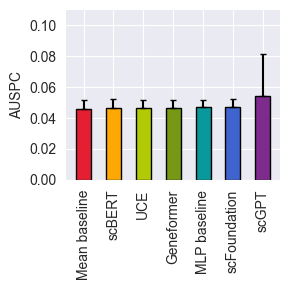

In [104]:
plt.figure(figsize=(3, 3))
table, yerr = find_auspc_table([df_mean, df_mlp, df_scbert, df_scgpt, df_gf, df_uce, df_scf], model_names=['Mean baseline', 'MLP baseline', 'scBERT', 'scGPT', 'Geneformer', 'UCE', 'scFoundation'])
table = pd.Series(table).sort_values()

yerr_values = [yerr[model] for model in table.index]

#cmap = load_cmap('Flourite')
cmap = load_cmap('Rainbow')
#cmap = load_cmap('RoseQuartz')
#cmap = load_cmap('Sardonyx')
bar_colors = [cmap(i/6) for i in range(7)]
    
width = 0.5

yerr_top_only = ([0] * len(yerr_values), yerr_values)

# Add error bars to the bar plot
bars = plt.bar(table.index, table, width, color=bar_colors, alpha=1.0, yerr=yerr_top_only, capsize=2, linewidth=1, edgecolor='black', 
               ecolor='black')

plt.ylabel('AUSPC')
plt.xticks(rotation=90)
plt.ylim(0.0, 0.11)

ax = plt.gca()
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig('paper_figs/auspc_bar_1.pdf', dpi=300)
plt.show()

## MSE per split / AUSPC bar plot for all models

In [108]:
test_mse = find_mets_by_spectral_params('mlp_norman', 'test/mse', df_mlp)
test_mse_uce = find_mets_by_spectral_params('uce', 'test/mse', df_uce)
test_mse_gf = find_mets_by_spectral_params('gf', 'test/mse', df_gf)
test_mse_scgpt = find_mets_by_spectral_params('scgpt', 'test/mse', df_scgpt)
test_mse_scbert = find_mets_by_spectral_params('scbert', 'test/mse', df_scbert)
test_mse_scf = find_mets_by_spectral_params('scfoundation', 'test/mse', df_scf)
test_mse_mean = find_mets_by_spectral_params('test_mean_norman', 'test/mse', df_mean)

KeyError: 'data.split'

In [ ]:
plot_spectral_curve(test_mse, shading=True, errbar=True, plot_shading_c_same=False)
plt.savefig('paper_figs/baseline_full_spec_curve.pdf', dpi=300)
plt.show()

## MSE bar plot for all models

In [ ]:
model_names = ['Mean baseline', 'MLP baseline', 'UCE', 'Geneformer', 'scGPT', 'scBERT', 'scFoundation']
model_mses = [test_mse_mean, test_mse, test_mse_uce, test_mse_gf, test_mse_scgpt, test_mse_scbert, test_mse_scf]

spectral_params = ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7'] 
x_labels = spectral_params
bars = []

dists_from_cent = [-1.25, -0.75, -0.25, 0.25, 0.75, 1.25, 1.5]  
plt.figure(figsize=(6, 3))

assert len(dists_from_cent) == len(model_names)
pivot = np.arange(len(x_labels)) # pivot points for bars/ticks

# Use the custom dark blue colormap
#cmap = load_cmap('Flourite')
cmap = load_cmap('Rainbow')
#cmap = load_cmap('RoseQuartz')
#cmap = load_cmap('Sardonyx')
bar_colors = [cmap(i/6) for i in range(7)]
width = 0.5

model_colors = {
    'MLP baseline': bar_colors[4],
    'Mean baseline': bar_colors[0],
    'scBERT': bar_colors[1],
    'UCE': bar_colors[2],
    'Geneformer': bar_colors[3],
    'scGPT': bar_colors[6],
    'scFoundation': bar_colors[5]
}

width = 0.1
for model, m_mse, dis_from_cent in zip(model_names, model_mses, dists_from_cent):
    c = model_colors[model]
    y = m_mse.mean()
    bar = [p + (dis_from_cent * width * 2.5) for p in pivot]
    bars.append(bar)
    plt.barh(bar, y, width, alpha=1.0,
    label=model,
    color=c,
    linewidth=0.3,  
    ecolor='black'
    )
    for rep in m_mse.iterrows():
        plt.scatter(rep[1], bar, color=c, edgecolors='black', linewidths=0.1, s=5)

plt.yticks(np.arange(8), spectral_params) #rotation='vertical')
plt.xlabel('MSE')
plt.ylabel('Sparsification Probability')
plt.legend(loc='lower right', fontsize=6)
plt.xlim(0.05, 0.16)

plt.tight_layout()
plt.savefig('paper_figs/bar_all_sp_mse.pdf', dpi=300)
plt.show()


## Tables with MSE results

In [ ]:
all_mean = {}
all_sd = {}
for m_name, m_mses in zip(model_names, model_mses):
    m_ave_mse = m_mses.mean(axis=0)
    m_sd_mse = m_mses.std(axis=0)
    new_idx = pd.Index([idx.split('_')[-1] for idx in m_ave_mse.index])
    m_ave_mse.index = new_idx
    m_sd_mse.index = new_idx
    all_mean[m_name] = pd.DataFrame(m_ave_mse)
    all_sd[m_name] = pd.DataFrame(m_sd_mse)

all_mean_df = pd.concat(all_mean, axis=1)
all_sd_df = pd.concat(all_sd, axis=1)
all_mean_df.columns = model_names
all_sd_df.columns = model_names

In [ ]:
all_mean_df

In [ ]:
all_sd_df